<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/multi_modal/cohere_multi_modal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal Retrieval using Cohere Multi-Modal Embeddings

[Cohere has released multi-modal embedding model](https://cohere.com/blog/multimodal-embed-3) and in this notebook, we will demonstrate `Multi-Modal Retrieval using Cohere MultiModal Embeddings`.

Why are MultiModal Embeddings important?

Multimodal embeddings are important because they allow AI systems to understand and search through both images and text in a unified way. Instead of having separate systems for text and image search, multimodal embeddings convert both types of content into the same embedding space, enabling users to find relevant information across different types of media for a given query.

For the demonstration, here are the steps:

1. Download text, images, and raw PDF files from related Wikipedia articles.
2. Build a Multi-Modal index for both texts and images using Cohere Multi-Modal Embeddings.
3. Retrieve relevant text and images simultaneously using a Multi-Modal Retriever for a query.
4. Generate responses using the Multi-Modal Query Engine for a query.

**NOTE:** We will use Anthropic's MultiModal LLM for response generation, as Cohere does not yet support MultiModal LLMs.

### Installation

We will use Cohere MultiModal embeddings for retrieval, Qdrant vector-store and Anthropic MultiModal LLM for response generation.

In [ ]:
%pip install llama-index-embeddings-cohere
%pip install llama-index-vector-stores-qdrant
%pip install llama-index-multi-modal-llms-anthropic

### Setup API Keys

Cohere - MultiModal Retrieval

Anthropic - MultiModal LLM.

In [ ]:
import os

os.environ["COHERE_API_KEY"] = "<YOUR COHERE API KEY>"

os.environ["ANTHROPIC_API_KEY"] = "<YOUR ANTHROPIC API KEY>"

### Utils

1. `get_wikipedia_images`: Get the image URLs from the Wikipedia page with the specified title.
2. `plot_images`: Plot the images in the specified list of image paths.
3. `delete_large_images`: Delete images larger than 5 MB in the specified directory.

**NOTE**: Cohere API accepts images of size less than 5MB.

In [ ]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import urllib.request
import os


def get_wikipedia_images(title):
    """
    Get the image URLs from the Wikipedia page with the specified title.
    """
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "imageinfo",
            "iiprop": "url|dimensions|mime",
            "generator": "images",
            "gimlimit": "50",
        },
    ).json()
    image_urls = []
    for page in response["query"]["pages"].values():
        if page["imageinfo"][0]["url"].endswith(".jpg") or page["imageinfo"][
            0
        ]["url"].endswith(".png"):
            image_urls.append(page["imageinfo"][0]["url"])
    return image_urls


def plot_images(image_paths):
    """
    Plot the images in the specified list of image paths.
    """
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


def delete_large_images(folder_path):
    """
    Delete images larger than 5 MB in the specified directory.
    """
    # List to hold the names of deleted image files
    deleted_images = []

    # Iterate through each file in the directory
    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith(
            (".png", ".jpg", ".jpeg", ".gif", ".bmp")
        ):
            # Construct the full file path
            file_path = os.path.join(folder_path, file_name)
            # Get the size of the file in bytes
            file_size = os.path.getsize(file_path)
            # Check if the file size is greater than 5 MB (5242880 bytes) and remove it
            if file_size > 5242880:
                os.remove(file_path)
                deleted_images.append(file_name)
                print(
                    f"Image: {file_name} was larger than 5 MB and has been deleted."
                )

### Donwload text and images from Wikipedia

We will download text and images associated from following wikipedia pages.

1. Audi e-tron
2. Ford Mustang
3. Porsche Taycan


In [ ]:
image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 10

wiki_titles = {
    "Audi e-tron",
    "Ford Mustang",
    "Porsche Taycan",
}


data_path = Path("mixed_wiki")
if not data_path.exists():
    Path.mkdir(data_path)

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

    images_per_wiki = 0
    try:
        list_img_urls = get_wikipedia_images(title)

        for url in list_img_urls:
            if (
                url.endswith(".jpg")
                or url.endswith(".png")
                or url.endswith(".svg")
            ):
                image_uuid += 1
                urllib.request.urlretrieve(
                    url, data_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        print(str(Exception("No images found for Wikipedia page: ")) + title)
        continue

### Delete larger image files

Cohere MultiModal Embedding model accepts less than 5MB file, so here we delete the larger image files.

In [ ]:
delete_large_images(data_path)

Image: 8.jpg was larger than 5 MB and has been deleted.
Image: 13.jpg was larger than 5 MB and has been deleted.
Image: 11.jpg was larger than 5 MB and has been deleted.
Image: 21.jpg was larger than 5 MB and has been deleted.
Image: 23.jpg was larger than 5 MB and has been deleted.
Image: 32.jpg was larger than 5 MB and has been deleted.
Image: 19.jpg was larger than 5 MB and has been deleted.
Image: 4.jpg was larger than 5 MB and has been deleted.
Image: 5.jpg was larger than 5 MB and has been deleted.
Image: 7.jpg was larger than 5 MB and has been deleted.
Image: 6.jpg was larger than 5 MB and has been deleted.
Image: 1.jpg was larger than 5 MB and has been deleted.


### Set Embedding Model and LLM.

Cohere MultiModal Embedding model for retrieval and Anthropic MultiModal LLM for response generation.

In [ ]:
from llama_index.embeddings.cohere import CohereEmbedding
from llama_index.multi_modal_llms.anthropic import AnthropicMultiModal
from llama_index.core import Settings

Settings.embed_model = CohereEmbedding(
    api_key=os.environ["COHERE_API_KEY"],
    model_name="embed-english-v3.0",  # current v3 models support multimodal embeddings
)

anthropic_multimodal_llm = AnthropicMultiModal(max_tokens=300)

### Load the data

We will load the downloaded text and image data.

In [ ]:
from llama_index.core import SimpleDirectoryReader

documents = SimpleDirectoryReader("./mixed_wiki/").load_data()

### Setup Qdrant VectorStore

We will use Qdrant vector-store for storing image and text embeddings and associated metadata.

In [ ]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import StorageContext

import qdrant_client

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_mm_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

### Create MultiModalVectorStoreIndex.

In [ ]:
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
    image_embed_model=Settings.embed_model,
)

### Test the Retrieval

Here we create a retriever and test it out.

In [ ]:
retriever_engine = index.as_retriever(
    similarity_top_k=4, image_similarity_top_k=4
)

In [ ]:
query = "Which models of Porsche are discussed here?"
retrieval_results = retriever_engine.retrieve(query)

#### Inspect the retrieval results

**Node ID:** ac3e92f1-e192-4aa5-bbc6-45674654d96f<br>**Similarity:** 0.49435770203542906<br>**Text:** === Aerodynamics ===
The Taycan Turbo has a drag coefficient of Cd=0.22, which the manufacturer claims is the lowest of any current Porsche model. The Turbo S model has a slightly higher drag coeff...<br>

**Node ID:** 045cde7c-963f-46cd-b820-9cabe07f1ab5<br>**Similarity:** 0.4804621315897337<br>**Text:** The Porsche Taycan is a battery electric luxury sports sedan and shooting brake car produced by German automobile manufacturer Porsche. The concept version of the Taycan named the Porsche Mission E...<br>

**Node ID:** e14475d1-7bd4-48f3-a085-f712d5bc7e5a<br>**Similarity:** 0.46787589674504015<br>**Text:** === Porsche Mission E Cross Turismo ===
The Porsche Mission E Cross Turismo previewed the Taycan Cross Turismo, and was presented at the 2018 Geneva Motor Show. The design language of the Mission E...<br>

**Node ID:** a25b3aea-2fdd-4ae2-b5bc-55eef453fe82<br>**Similarity:** 0.4370399571869162<br>**Text:** == Specifications ==


=== Chassis ===
The Taycan's body is mainly steel and aluminium joined by different bonding techniques. The body's B pillars, side roof frame and seat cross member are made f...<br>

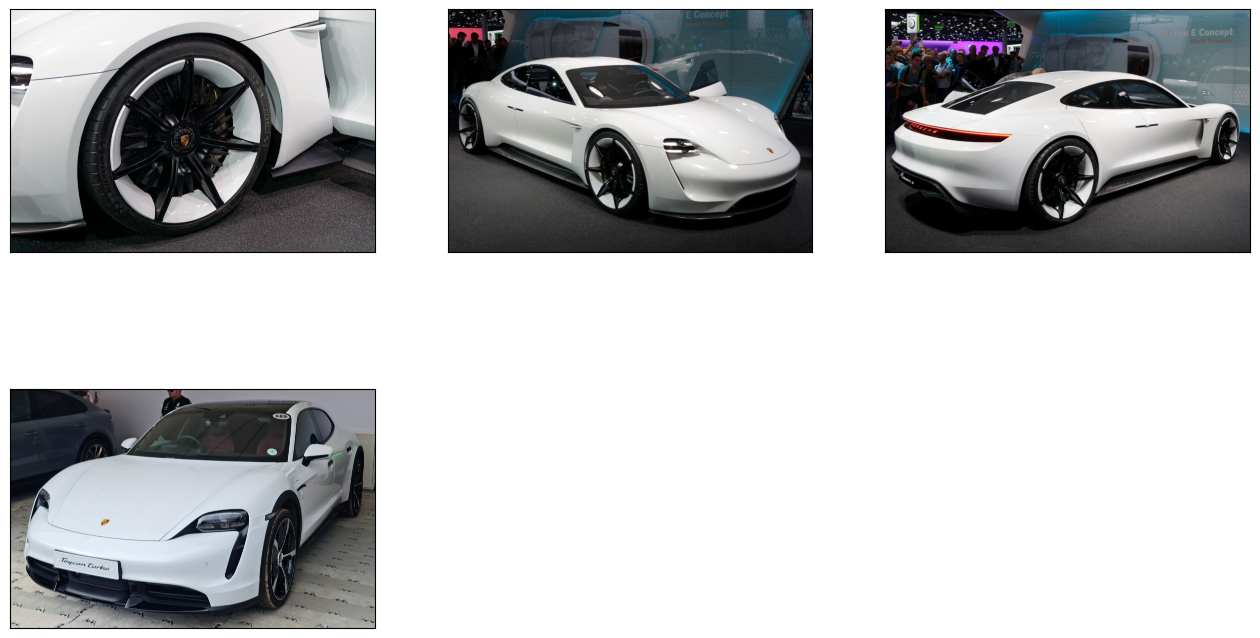

In [ ]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

### Test the MultiModal QueryEngine

We will create a `QueryEngine` by using the above `MultiModalVectorStoreIndex`.

In [ ]:
from llama_index.core import PromptTemplate

qa_tmpl_str = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    llm=anthropic_multimodal_llm, text_qa_template=qa_tmpl
)

In [ ]:
query = "Which models of Porsche are discussed here?"
response = query_engine.query(query)

In [ ]:
print(str(response))

Based on the context provided, the Porsche models discussed are:

- Porsche Taycan - a battery electric luxury sports sedan. It is offered in several variants at different performance levels, including the Taycan Turbo and Turbo S high-performance AWD models, the mid-range Taycan 4S, and a base RWD model.

- Porsche Taycan Cross Turismo - a lifted shooting brake/wagon version of the Taycan with crossover-like features and styling. 

- Porsche Taycan Sport Turismo - shares the shooting brake profile with the Cross Turismo but without the crossover styling elements. A RWD version is available as the base Taycan Sport Turismo.

- Porsche Mission E - the concept car unveiled in 2015 that previewed the design and technology of the production Taycan models.


#### Inspect the sources

**Node ID:** ac3e92f1-e192-4aa5-bbc6-45674654d96f<br>**Similarity:** 0.49435770203542906<br>**Text:** === Aerodynamics ===
The Taycan Turbo has a drag coefficient of Cd=0.22, which the manufacturer claims is the lowest of any current Porsche model. The Turbo S model has a slightly higher drag coeff...<br>

**Node ID:** 045cde7c-963f-46cd-b820-9cabe07f1ab5<br>**Similarity:** 0.4804621315897337<br>**Text:** The Porsche Taycan is a battery electric luxury sports sedan and shooting brake car produced by German automobile manufacturer Porsche. The concept version of the Taycan named the Porsche Mission E...<br>

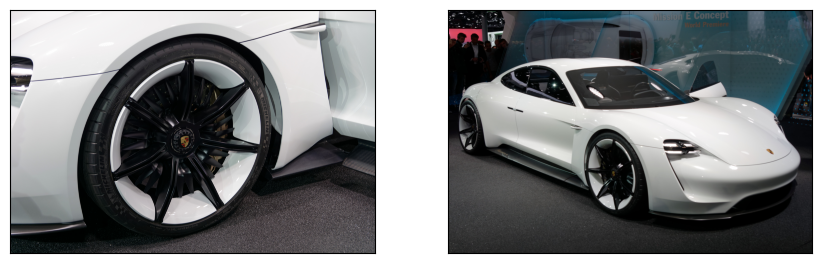

In [ ]:
from llama_index.core.response.notebook_utils import display_source_node

for text_node in response.metadata["text_nodes"]:
    display_source_node(text_node, source_length=200)
plot_images(
    [n.metadata["file_path"] for n in response.metadata["image_nodes"]]
)